<a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/Cryosphere/CIE4602_RSAssignment_2020_21_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)

# Remote sensing of snow/ice properties from multi-source remote sensing data 
*Created by Stef Lhermitte (s.lhermitte at tudelft.nl |  [@steflhermitte](https://twitter.com/StefLhermitte) | [www.earthmapps.io](http://www.earthmapps.io))*

*with fragments from*

* [the Tartes help](http://pp.ige-grenoble.fr/pageperso/picardgh/tartes/)
* [the SMRT getting started page](https://www.smrt-model.science/getstarted.html)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Q4qtC7mFKv8ogXMEYhM4g-GLfp-CDgJb?usp=sharing) 
[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)




# Assignment Introduction
Within this assignment you will use remote sensing data from optical, passive microwave and SAR satellite data in combination of radiative transfer models (i.e., [TARTES](http://pp.ige-grenoble.fr/pageperso/picardgh/tartes/) for VNIR wavelengths and [SMRT](https://www.smrt-model.science/) for MW wavelengths) to assess the effect of snow/ice properties on the remote sensing signals.
The objective of this assignment is that you:
 - Explore and understand the effects of snow/ice property changes on the satellite signals
 - Implement simple radiative transfer models to simulate the snow/ice signal for remote sensing analysis
 - Experiment with a methodology to extract surface properties from multi-source satellite albedo data


## Package installation

Here we install all the necessary packages. You can also install the packages on your own computer if your prefer. For more information on how to install these packages yourself: please check the respective model websites of [TARTES](http://pp.ige-grenoble.fr/pageperso/picardgh/tartes/) and [SMRT](https://www.smrt-model.science/).

In [ ]:
!pip install tartes
!pip install numpy scipy xarray pandas sixc
!pip install git+https://github.com/smrt-model/smrt.git

     |████████████████████████████████| 573kB 4.5MB/s 
  Created wheel for tartes: filename=tartes-1.4-cp37-none-any.whl size=44921 sha256=e41ce501ec86b360c7431058ecd2dc1cac31954dc87da1f168d47c330450aedf
  Stored in directory: /root/.cache/pip/wheels/83/80/bf/def77bc23498ce03c7f98276f99562da91f5f32cca5cb6995f
Successfully built tartes
ERROR: Could not find a version that satisfies the requirement sixc (from versions: none)
ERROR: No matching distribution found for sixc
  Cloning https://github.com/smrt-model/smrt.git to /tmp/pip-req-build-nv9frfvz
  Running command git clone -q https://github.com/smrt-model/smrt.git /tmp/pip-req-build-nv9frfvz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for smrt: filename=smrt-1.0.2-cp37-none-any.whl size=211242 sha256=79efa1c82685c54c6d52ba40adcba57c189d2a360abab167bbaa13df95f911e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-0se2ubw2/wheels/67/f3/62

# Introduction to TARTES
*Derived from http://pp.ige-grenoble.fr/pageperso/picardgh/tartes/*

To compute the diffuse albedo (hemispherical-hemispherical reflectance) of an homogeneous snowpack with SSA=20 kg m-2 at 850nm, use the following script:



In [ ]:
import tartes

ssa = 20      # in m^2/kg
density = 300  # in kg/m^3
# the result should be independent of the density for a semi-infinite medium

wavelength = 850e-9  # in m

albedo = tartes.albedo(wavelength, ssa, density)

print(albedo)

0.8812851442261855



The first line import the tartes module, the next two lines define the snowpack (here a single layer / homogeneous semi-infinite medium as the thickness argument is not given), and the wavelength(s) at which the calculation will be done. The albedo function performs the computation using TARTES and return the albedo. The last line print the result which should be about 0.8812. If 'optical radius' sounds more familiar than SSA to you, the conversion can be done using the function ssa as follow:


In [ ]:
import tartes
from tartes import ssa

r_opt = 100e-6      # in m
density = 300       # in kg/m^3
# the result should be independent of the density for a semi-infinite medium

wavelength = 850e-9  # in m

albedo = tartes.albedo(wavelength, ssa(r_opt), density)

print(albedo)

0.9058242408908693


The results should be 0.9058.
Note that the diffuse albedo is calculated assuming a directional reflectance at 53° incidence angle rather than a proper integration over all the zenith angle.
To compute the direct albedo (directional-hemispherical reflectance), set the optional parameters dir_frac=1 and sza the solar zenith angle in degree.

In [ ]:
import tartes

ssa = 20      # in m^2/kg
density = 300  # in kg/m^3
# the result should be independent of the density for a semi-infinite medium

wavelength = 850e-9  # in m

albedo = tartes.albedo(wavelength, ssa, density, dir_frac=1, sza=30)

print(albedo)

0.8583967584060925


The result should be 0.8584.
To compute and plot the spectrum of diffuse albedo between 300 and 2500 nm with a 10-nm resolution for the same snowpack, use a sequence (list, numpy array, ...) for the wavelength argument:

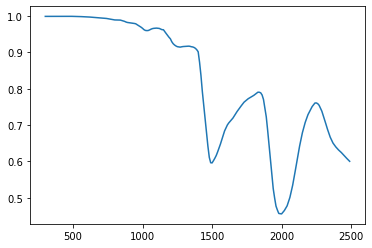

In [ ]:
import tartes
from pylab import *


ssa = 2000      # in m^2/kg
density = 300  # in kg/m^3

wavelengths = arange(300, 2500, 10)*1e-9  # from 300 to 2500nm

albedo = tartes.albedo(wavelengths, ssa, density)

plot(wavelengths*1e9, albedo)
show()

For a multi-layered snowpack, the SSA, density and thickness are sequences (list, numpy array, ...) or a constant value if the property is constant throughout the profile. All the sequences must have the same length (= the number of layers).

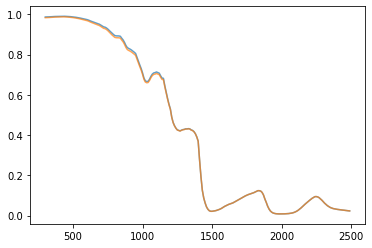

In [ ]:
import tartes
from pylab import *


ssa = [20, 15, 10]         # in m^2/kg
density = [200, 250, 300]  # in kg/m^3
thickness = [0.01, 0.10, 1000]  # thickness of each layer in meter
wavelengths = arange(300, 2500, 10)*1e-9  # from 300 to 2500 nm

albedo_3layers = tartes.albedo(wavelengths, ssa, density, thickness)

ssa = 20         # in m^2/kg
density = 300    # in kg/m^3
albedo_semiinfinite = tartes.albedo(wavelengths, ssa, density)


# alpha controls the transparency of the curves
plot(wavelengths*1e9, albedo_semiinfinite, alpha=0.7)
plot(wavelengths*1e9, albedo_3layers, alpha=0.7)
show()

The albedo of the underlying layer (soil, ice, ...) can be set by using the soilalbedo optional parameter. For instance to test the influence of the thickness of a shallow snowpack overlying a dark surface (albedo = 0.2):



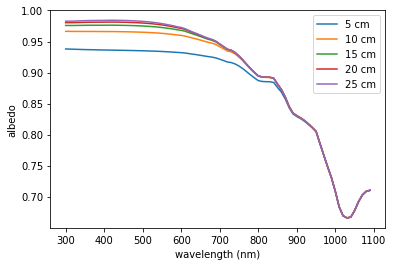

In [ ]:
import tartes
from pylab import *

ssa = 20         # in m^2/kg
density = 250    # in kg/m^3


thickness = arange(5, 30, 5)*1e-2
wavelengths = arange(300, 1100, 10)*1e-9  # from 300 to 1100nm

for th in thickness:
    albedo = tartes.albedo(wavelengths, ssa, density, th, soilalbedo=0.2)
    plot(wavelengths*1e9, albedo, label='%g cm' % (th*100))

legend(loc='best')
xlabel('wavelength (nm)')
ylabel('albedo')
show()

Impurities are frequent in snow. TARTES is able to compute optical properties of dirty snow provided that the impurity particle size is small with respect to the wavelength (typically less than 500 nm), and their concentration is moderate so that the single scattering albedo remains close to one. The absorption spectrum of different species is provided and new ones can be implemented by the users (see tartes.impurities module). Both the content and the species need to be specified as inputs. Soot is the default species if not specified. The simple example below shows the difference between the reflectance spectra of a semi-infinite snowpack containing soot or HULIS:

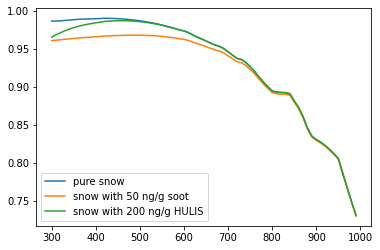

In [ ]:
import tartes.impurities
from pylab import *


ssa = 20      # in m^2/kg
density = 300  # in kg/m^3

wavelengths = arange(300, 1000, 10)*1e-9  # from 300 to 2500nm

# pure snow
albedo_pure = tartes.albedo(wavelengths, ssa, density)

# 50ng/g of soot. Soot is the default impurity type
albedo_soot = tartes.albedo(wavelengths, ssa, density, impurities=50e-9)


# 200ng/g of Hulis.
albedo_hulis = tartes.albedo(wavelengths, ssa, density,
                             impurities=200e-9,
                             impurities_type=tartes.impurities.HULIS)


plot(wavelengths*1e9, albedo_pure, label='pure snow')
plot(wavelengths*1e9, albedo_soot, label='snow with 50 ng/g soot')
plot(wavelengths*1e9, albedo_hulis, label='snow with 200 ng/g HULIS')
legend(loc='best')
show()

# Introduction to SMRT
To compute the brightness temperature for passive microwave or the radar backscatter for active microwave signals you basically always need to follow 3 steps: 1) make a snowpack, 2) configure a sensor, 3) select the radiative transfer solver, the electromagnetic theory and the microstructure, 4) run the model, and 5) inspect the result to get brightness temperature or backscattering coefficient at different polarizations, incidence angles, etc.



### Step 1: Make a snowpack


#### Single layer snowpacks
To define a single layer, deep snowpack we need to know the layer thickness, temperature, sticky hard sphere radius, stickiness and density:

In [ ]:
from smrt import make_snowpack, make_model

# Define parameters (All Units are in SI)
thickness = [10]
temperature = [265]
rad = [1e-4]
rho = [280]
stickiness = [0.2]

# Make snowpack with 'sticky_hard_spheres' microstructure model
snowpack = make_snowpack(thickness=thickness, 
                         microstructure_model='sticky_hard_spheres',
                         temperature=temperature, radius=rad, density=rho,
                         stickiness=stickiness)

# Make snowpack with 'exponential' microstructure model
snowpack = make_snowpack(thickness=thickness, 
                         microstructure_model='exponential',
                         temperature=temperature, density=rho,
                         corr_length=[5e-5])

#### Multi-layer snowpacks
To create a multi-layer snowpack we just need to extend the information per layer

In [ ]:
# Define parameters (All Units are in SI)
thickness = [10,10]
temperature = [265,265] 
# All variables can be defined as a number (equal for all layert) or a list of numbers per layer
temperature = 265
rad = [1e-4,2e-4]
rho = 280
stickiness = [0.2,0.3]

# Make snowpack
snowpack = make_snowpack(thickness=thickness, 
                         microstructure_model='sticky_hard_spheres',
                         temperature=temperature, radius=rad, density=rho,
                         stickiness=stickiness)

A snowpack is a list of layers objects, which we can access and explore.

In [ ]:
print(snowpack.layers[0].temperature)
print(snowpack.layers[1].temperature)
dir(snowpack.layers[1])

265.0
265.0


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ssa',
 'basic_checks',
 'density',
 'frac_volume',
 'inclusion_shape',
 'inverted_medium',
 'liquid_water',
 'microstructure',
 'microstructure_model',
 'number',
 'permittivity',
 'permittivity_model',
 'salinity',
 'ssa',
 'temperature',
 'thickness']

We can also draw a snowpack:

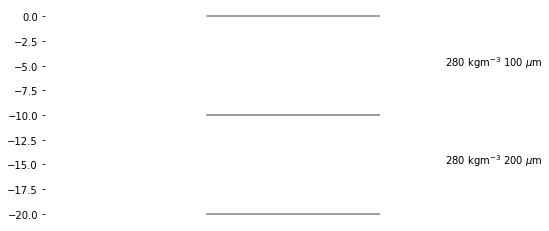

In [ ]:
from smrt.utils.mpl_plots import plot_snowpack

plt.figure()
plot_snowpack(snowpack, show_vars=['density', 'radius'])

#### Wet snow
To create wet snow, you need to set the liquid water content. If you do that, you will see that the permitivity changes:

In [ ]:
from smrt import make_snowpack
# prepare the multi-layer snowpack
radius = 100e-6
density=300
temperature = 260
sp = make_snowpack(thickness=[0.1, 10],
                   microstructure_model='sticky_hard_spheres',
                   density=density,
                   radius=radius,                   
                   stickiness=0.15,
                   temperature=temperature,
                   liquid_water=[0, 0])

print(sp.layers[0].permittivity(1, 10e9))

sp = make_snowpack(thickness=[0.1, 10],
                   microstructure_model='sticky_hard_spheres',
                   density=density,
                   radius=radius,                   
                   stickiness=0.15,
                   temperature=temperature,
                  #  ice_permittivity_model=wetsnow_permittivity,
                   liquid_water=[0.1, 0])

print(sp.layers[0].permittivity(1, 10e9))

(3.1764335000000004+0.0007272578757053208j)
(4.751382379433089+2.4718522409197083j)


#### Substrate

If your snowpack is not indefinitely thick, it is also important to add a relevant substrate of known reflectivity or and a soil, ice, etc.

In [ ]:
from smrt.substrate.reflector_backscatter import make_reflector
temperature = 273

# Create substrate from known reflectivity
substrate = make_reflector(temperature=265, specular_reflection=0.02)

# Or alternatively create substrate from soil 
from smrt import make_soil
soil = make_soil('soil_wegmuller', 'dobson85', temperature=265, roughness_rms=0.25, 
                 moisture=0.25, sand=0.01, clay=0.7, drymatter=1300)

# Or alternatively create substrate from ice
from smrt import make_ice_column 
ice  =  make_ice_column('fresh', thickness=[10], microstructure_model='exponential', 
                     temperature=temperature, corr_length=[5e-5])

# You can do something similar for an active MW sensor
reflector = make_reflector(temperature=265, specular_reflection=0., backscattering_coefficient={'VV': 0.1, 'HH': 0.1})

# Define a snowpack
snow = make_snowpack([0.01], "exponential", temperature=[265], density=[280], corr_length=[5e-5])
# sp = make_snowpack(thickness=[0.1, 10],
#                    microstructure_model='sticky_hard_spheres',
#                    density=density,
#                    radius=radius,                   
#                    stickiness=0.15,
#                    temperature=temperature,
#                    liquid_water=[0, 0])

# You can subsequently add the substrate, soil, ice or reflector to your snowpack by using the + operator (works also with +=):
medium = snow + ice

# And now continue

### Step 2: Prepare a sensor
The sensor configuration includes all the information describing the sensor viewing geometry (incidence, …) and operating parameters (frequency, polarization, …). The generic functions `passive()` and `active()` should cover all the usages, but functions for specific sensors are more convenient. Check the [documentation](https://smrt.readthedocs.io/en/latest/smrt.inputs.sensor_list.html) for more info

In [ ]:
from smrt import sensor, sensor_list
radiometer = sensor.passive(18e9, 50)
radiometer = sensor.passive(18e9, 50, "V")
radiometer = sensor.passive([18e9,36.5e9], [50,55], ["V","H"])
scatterometer = sensor.active(frequency=18e9, theta_inc=50)
scatterometer = sensor.active(5.405e9, 50)
# scatterometer = sensor.active([18e9,36.5e9], theta=50, theta_inc=50, polarization_inc=["V", "H"], polarization=["V", "H"])
radar = sensor_list.active(5.405e9, 35)

### Step 3 & 4: Set the RT solver and run it
For now we will use IBA electromagnetic model with the discrete ordinates solver (DORT)

In [ ]:
n_max_stream= 128
m = make_model("iba", "dort", rtsolver_options ={"n_max_stream": n_max_stream})
#m = make_model('iba','dort')
result = m.run(scatterometer, medium)

### Step 5: Analyze the result

In [ ]:
print(result.sigmaVV_dB())
# print(result.TbH())


-70.77676167097754


Or here you can see a complete example

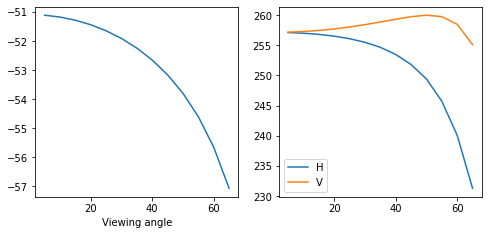

In [ ]:
# prepare the snowpack
radius = 10e-6
density=300
temperature = 260
sp = make_snowpack(thickness=[1000], microstructure_model='sticky_hard_spheres',
                  density=density, radius=radius, temperature=temperature,
                  stickiness=0.15)
# prepare a list for theta from 5 to 65 by step of 5
theta = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
# prepare two sensors (one active, on passive) at 13 GHz
radiometer = sensor.passive(13e9, theta)
radar  = sensor.active(13e9, theta)

# prepare the model and run it successively for each sensor
m = make_model("iba", "dort")
res_a = m.run(radar, sp)
res_p = m.run(radiometer, sp)

# for plotting two side by side graphs, the best solution is:
f, axs = plt.subplots(1, 2, figsize=(8, 3.5))

# plot on left graph 
axs[0].plot(theta, res_a.sigmaVV_dB()) # adapt x and y to your need
# plot on right graph
axs[1].plot(theta, res_p.TbH(),label='H')  # adapt x and y to your need
axs[1].plot(theta, res_p.TbV(),label='V')  # adapt x and y to your need

# to set axis labels:
axs[0].set_xlabel("Viewing angle")
legend(loc='best')
# ...

### Step 6: Sensitivity analysis
SMRT allows to do sensitivity analyses easily. I refer to the [package example](https://github.com/smrt-model/runningsmrt/blob/master/tutorials/sensitivity_study.ipynb) to check how this can be done.

### Step 7: Time series analysis
The run() method can be used with list of snowpacks, which is useful if you want to apply it to for example a time series. In this case, it is recommended to set the snowpack_dimension_name and snowpack_dimension_values variable which gives the name and values of the coordinates that are create for the Results. 

In [ ]:
snowpacks = []
times = []
for file in filenames:
    #  create a snowpack for each time series
    sp = ...
    snowpacks.append(sp)
    times.append(sp)

# now run the model
res = m.run(sensor, snowpacks, snowpack_dimension=('time', times))

# Introduction to AWS data
For this assignment you are going to work with satellite data over the DYE-2 automatic weather station on the Greenland Ice Sheet. The data originally come from *Baptiste Vandecrux. 2020. Gap-filled meteorological data and surface energy balance at nine Greenland Climate Network (GC-Net) stations over 1998-2017. Arctic Data Center. doi:10.18739/A2HM52K87*, but you can find the file on Brightspace and you should upload it to Colab by uploading it to the files section on the left. Once uploaded, it is rather straightforward to access, plot the data or use standard subsetting, indexing approaches etc.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


Text(0.5, 0, 'Date')

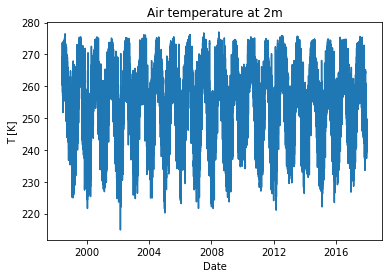

In [ ]:
from scipy.io import netcdf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, datetime, timedelta

file = netcdf.NetCDFFile('Dye_2_surface.nc','r')

temp = file.variables['time']     # [days] since 1900-1-1 0:0:0 UTC
datet = [date(1900,1,1) + timedelta(i) for i in temp[:]]

temp = file.variables['Ta_2m']
airtemp = temp[:].byteswap().newbyteorder()                   # [K] at 2 m

temp = file.variables['RH_2m']
relhum = temp[:]                    # [%] at 2 m

temp = file.variables['WS_10m']
windsp = temp[:]                    # [m/s] at 10 m

temp = file.variables['SRin']
shortdown = temp[:]                 # [W/m^2]

temp = file.variables['SRout']
shortup = temp[:]                   # [W/m^2]

albedo = shortup/shortdown

temp = file.variables['LRin']
longdown = temp[:]                  # [W/m^2]

temp = file.variables['snowfall']
precip = temp[:]                    # [m/hr] not mm! 

file.close()

# plotting air temperature to check: 
plt.plot(datet, airtemp)
plt.title('Air temperature at 2m')
plt.ylabel('T [K]')
plt.xlabel('Date')

In [ ]:
# Calculate daily mean
dat = pd.Series(airtemp, index=pd.to_datetime(datet))
ta2_mean = dat.resample('D').median()
ta2_mean

1998-06-01    269.159546
1998-06-02    267.819540
1998-06-03    266.519537
1998-06-04    266.304541
1998-06-05    267.489235
                 ...    
2017-12-27    245.858262
2017-12-28    248.199349
2017-12-29    244.294149
2017-12-30    245.616559
2017-12-31    245.212529
Freq: D, Length: 7154, dtype: float64

Text(0.5, 0, 'Date')

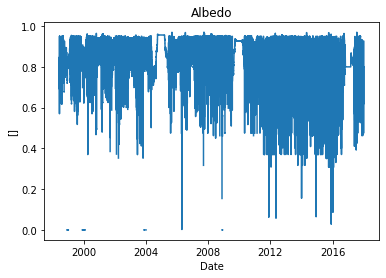

In [ ]:
plt.plot(datet, albedo)
plt.title('Albedo')
plt.ylabel('[]')
plt.xlabel('Date')

# Remote sensing data over AWS
At the same time you can find the corresponding [MODIS MCD43 albedo](https://lpdaac.usgs.gov/products/mcd43a3v006/), [SSMI](https://en.wikipedia.org/wiki/Special_sensor_microwave/imager) (19-37GhZ) and Sentinel-1 backscatter observations. The SSMI data was processed by Dylan Kreynen and contains the necessary metadata as a readme file. The MODIS and Sentinel-1 data were processed on the Google Earth Engine using this [script](https://code.earthengine.google.com/eb310a5378cf2b6b7e2f454f11c60682)

In [ ]:
# Load the SSMI data

# These numpy files contain SSM/I and SSMIS observed brightness temperatures over the DYE-2 
# site on the Greenland Ice Sheet (66°29′N 46°18′W), for the 19.35 and 37 GHz channels. 
# Observations run from 01-06-1998 to 31-12-2017 and are daily, from the F13 and F17 satellite 
# platforms. For dates where both F13 and F17 data was available, the mean value was taken. 

# SSMI_37.npy - 37.00 GHz, V (1st row) and H (2nd row) channel
# SSMI_19.npy - 19.35 GHz, V (1st row) and H (2nd row) channel
# SSMI_dates.npy - dates of the observations (yyyy-mm-dd)

# Source: 
# Meier, W. N., H. Wilcox, M. A. Hardman, and J. S. Stewart. 2019. DMSP SSM/I-SSMIS Daily Polar 
# Gridded Brightness Temperatures, Version 5. Boulder, Colorado USA. NASA National Snow and Ice 
# Data Center Distributed Active Archive Center. doi: https://doi.org/10.5067/QU2UYQ6T0B3P. 

# Accessed through: 
# https://nsidc.org/data/NSIDC-0001/versions/5

# Dylan Kreynen - TU Delft - Feb 2021

s37 = np.load('/content/SSMI_37.npy')
s19 = np.load('/content/SSMI_19.npy')
sd = np.load('/content/SSMI_dates.npy')
datess = np.array([datetime.strptime(i, '%Y-%m-%d') for i in sd[0]])

f, axs = plt.subplots(1, 2, figsize=(8, 3.5))
axs[0].plot(datess,s19[0,:],label='V')
axs[0].plot(datess,s19[1,:],label='H')
axs[1].plot(datess,s37[0,:],label='V')
axs[1].plot(datess,s37[1,:],label='H')
legend(loc='best')

     system:index  BSA_Band1  BSA_Band2  ...  WSA_vis           time  .geo
0      2000_02_24        NaN        NaN  ...      NaN   951350400000   NaN
1      2000_02_25        NaN        NaN  ...      NaN   951436800000   NaN
2      2000_02_26      980.0      920.0  ...    915.0   951523200000   NaN
3      2000_02_27      978.0      918.0  ...    915.0   951609600000   NaN
4      2000_02_28      976.0      915.0  ...    914.0   951696000000   NaN
...           ...        ...        ...  ...      ...            ...   ...
7607   2020_12_27        NaN        NaN  ...      NaN  1609027200000   NaN
7608   2020_12_28        NaN        NaN  ...      NaN  1609113600000   NaN
7609   2020_12_29        NaN        NaN  ...      NaN  1609200000000   NaN
7610   2020_12_30        NaN        NaN  ...      NaN  1609286400000   NaN
7611   2020_12_31        NaN        NaN  ...      NaN  1609372800000   NaN

[7612 rows x 23 columns]


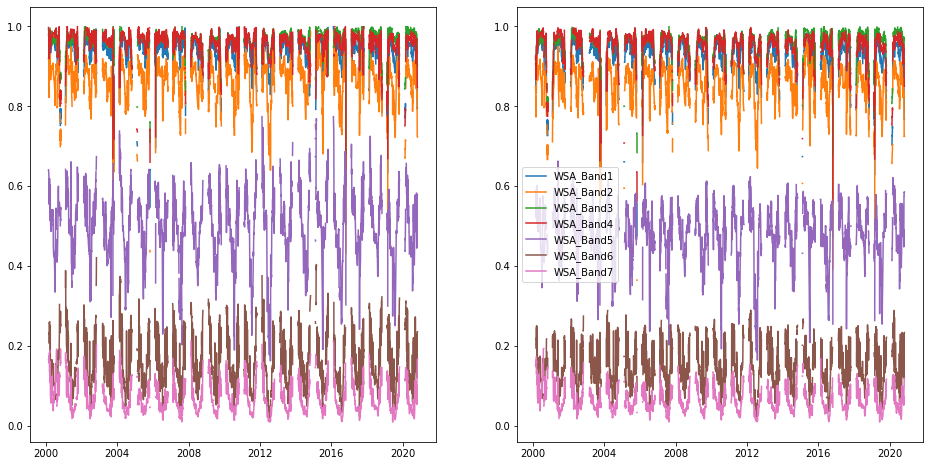

In [ ]:
# Load the MODIS data
import pandas
MOD = pandas.read_csv('MOD_ts.csv')
print(MOD)
dates = pandas.to_datetime(MOD['time'],unit='ms')
f, axs = plt.subplots(1, 2, figsize=(16, 8))
for i in range(7):
  axs[0].plot(dates,MOD['BSA_Band'+str(i+1)]/1000,label='BSA_Band'+str(i+1))
  axs[1].plot(dates,MOD['WSA_Band'+str(i+1)]/1000,label='WSA_Band'+str(i+1))
axs[1].legend(loc='best')

In [ ]:
# Load the Sentinel-1 data
import pandas
S1 = pandas.read_csv('S1_ts.csv')
print(S1['time'])
dates = pandas.to_datetime(S1['time'],unit='ms')
f, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].scatter(dates,S1['HH'],label='HH')
axs[0].scatter(dates,S1['HV'],label='HV')
axs[1].scatter(dates,S1['angle'],label='angle')
axs[1].legend(loc='best')

FileNotFoundError: ignored

# Assignment

## A1: Assess the effect snow properties on albedo

Task: use Tartes to assess the effect of snow properties on albedo. You need to do this by means of a sensivity analyses where you plot the spectral albedo over the 350-2500nm range vary the input parameters relative to 
create a reference single layer snowpack with approximate grain size, density and soot content.



### Question 1
Perform a sensitivity analysis of the diffuse albedo in function of the grain size (e.g. for grain sizes ranging from 50µm to 2mm). 

Plot the resulting spectral albedos over the 400-2500nm range. 

Discuss this figure and explain the differences you see.



### Question 2
Perform a sensitivity analysis of the diffuse albedo in function of the soot content (e.g. for soot contents ranging from 50ng/g to 1mg/g).

Plot the resulting spectral albedos over the 400-2500nm range.

Discuss this figure and explain the differences you see.

### Question 3
Create a single layer snowpack that resembles an ice layer. 

Plot the diffuse spectral albedo over the 400-2500nm range.  

Perform two sensitivity analysis by adding a fresh snow layer of i) different thickness (e.g. ranging from 1mm to 20 cm) and ii) grain size (e.g. ranging from 50µm to 1mm) on top of the ice layer.  

Plot the results of the sensitivity analysis over the 400-2500nm range.  

Discuss this figure and explain the differences you see.by specifically addressing how the snow layer affects the spectral albedo. 

### Question 4a
Create a reference snowpack.

Perform a sensitivity analysis of the spectral albedo to i) diffuse and direct radiation and ii) varying solar zenith angles (e.g. by varying the SZA between 0 and 85 degrees).

Plot the diffuse and spectral spectral albedo for the different SZA's over the 400-2500nm range.

Discuss this figure and how SZA and incoming radiation affect the spectral albedo.

### Question 4b
Convert the diffuse and direct spectral albedos of Q4a into a broadband albedo value. For this exercise you can use the incoming solar radiation derived by [COART](https://cloudsgate2.larc.nasa.gov/jin/coart.html), which is included in the data folder.

Plot the broadband albedo as a function of the illumination conditions (X-axis:SZA; Y-axis:broadband albedo). 

Discuss your result and specifically address how SZA and incoming radiation affect the broadband albedo.


### Question 5

Use the previous figures to discuss the relative importance of grain size, impurities and solar zenith angle on albedo. Thereby, address the magnitude of the changes, the spectral wavelengts where the differences can be seen etc.

## A2: Snow properties from the MODIS spectral albedo over DYE-2

Create a lookup table (LUT) that contains the diffuse spectral albedo at the MODIS wavelengths as a function grain size and soot content. Use this LUT to invert the snow properties (soot content and grain size) from the MODIS time series over DYE-2. For this purpose you can focus on the MODIS WSA data only (i.e. for simplicity you can assume that all incoming radiation is diffuse) and you can convert the satellite data to surface properties by maximizing the similarity between your Tartes LUT of spectral albedo and satellite spectral albedo data. This can be done for example by minimizing the cost function of: 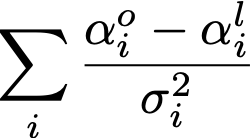 where:
-  `i` is the MODIS band corresponding the MODIS [wavelengths](https://modis.gsfc.nasa.gov/about/specifications.php)
- `\alpha_i^o ` is the observed MODIS diffuse spectral albedo for band i
- `\alpha_i^l ` is the LUT diffuse spectral albedo for band `i`
- `\sigma_i` is the standard deviation of LUT spectral albedos in band `i`

After this similarity maximization (i.e. cost minimazation), you can select the corresponding input data (soot, grain size) and read out the properties.

### Question 6

Plot the obtained time series of obtained grain size and soot content for i) the whole time series and ii) for one year. 

Plot the temperature, albedo and snowfall data of AWS for the same periods.

Discuss the results of your snow property retrieval algorithm by comparing it with the temperature, albedo and snowfall data of AWS. What similarities/differences do you see between the drivers (atmospheric conditions) and the outcome of your retrieval. Can you explain these similarities/differences physically (e.g. as a function of the expected snow conditions and/or satellite setup)? 


Discuss the role of climate change and/or interannual variability on both the satellite and AWS observations (Check [Dumont et. al.](https://www.nature.com/articles/ngeo2180) for more background)?


## A3: Asses the effect of snow properties on MW brightness temperature and backscatter

Task: create a reference single layer snowpack with approximate temperature, sticky hard sphere radius, stickiness and density and calculate i) the [SSMI](https://en.wikipedia.org/wiki/Special_sensor_microwave/imager) brightness temperature (19.35 and 37 GhZ frequencues in both H and V polarisation) and ii) [Sentinel-1](https://earth.esa.int/web/eoportal/satellite-missions/c-missions/copernicus-sentinel-1;jsessionid=1488A2BCD2550E1350E7DD16C3308C20.jvm1) backscatter using SMRT.


### Question 7
Perform a sensitivity analysis of brightness temperature and backscatter for the reference snowpack in function of the temperature (e.g. by varying the temperature between 250K and 290K). 

Plot the results showing the i) brightness temperature and ii) backscatter (Y-axis) as a function of snowpack temperature (X-axis).

Discuss this figure and explain how temperature affects brightness temperature and backscatter in different frequencies and polarisations. Also specifically address the effect of reaching the melting point: is this analysis output realistic or not? What is the effect you see vs. what you expect to see?

### Question 8a
Perform a sensitivity analysis of brightness temperature and backscatter in function of the snow thickness (e.g. by varying the snowpack thickness of the reference snowpack over a soil substrate between 0mm and 10m). 

Plot the results showing the i) brightness temperature and ii) backscatter (Y-axis) as a function of snowpack thickness (X-axis).

Discuss this figure and explain how snowpack thickness affects brightness temperature and backscatter in different frequencies and polarisations. 


### Question 8b
Repeat question 8a but now with a ice substrate instead of a soil substrate. 

Discuss the differences between the results of 8a and 8b and specifically address how the substrate affects the differences in brightness temperature and backscatter. What can you learn from these differences about retrieving snow depth over a soil vs. an ice sheet?


### Question 9
Perform a sensitivity analysis of brightness temperature and backscatter in function of the snow grain size  (e.g. by varying the grain size of the reference snowpack from 50µm to 2mm). 

Plot the results showing the i) brightness temperature and ii) backscatter (Y-axis) as a function of grain size (X-axis).

Discuss this figure and explain how snowpack grain size affects brightness temperature and backscatter in different frequencies and polarisations. 


### Question 10
Perform a sensitivity analysis of brightness temperature and backscatter in function of the liquid water content  (e.g. by varying the LWC of the reference snowpack over a from 0 to 5%). 

Plot the results showing the i) brightness temperature and ii) backscatter (Y-axis) as a function of LWC (X-axis).

Discuss this figure and explain how LWC affects brightness temperature and backscatter in different frequencies and polarisations. 

Compare your results with Q7 and discuss the shortcomings of the temperature-only analysis on Q7.


### Question 11
Perform a sensitivity analysis of brightness temperature and backscatter in function of the satellite zenith angle  (e.g. by varying the SZA from 0 to 80 degrees). 

Plot the results showing the i) brightness temperature and ii) backscatter (Y-axis) as a function of SZA (X-axis).

Discuss this figure and explain how SZA affects brightness temperature and backscatter in different frequencies and polarisations. What are the implications of this change on potential satellite data retrievals?


### Question 12
Use the previous figures to discuss the relative importance of temperature, grain size, liquid water content and satellite zenith angle on the satellite observations. Thereby, discuss how these affect the satellite signal and how that can be used to retrieve snow properties?


## A4: Snow properties from active and passive MW over DYE-2

### Question 13
Create a time series of modelled SMRT brightness temperature and Sentinel-1 backscatter for the reference snowpack where you may assume that the snowpack has the same temperature as the air temperature. For computational efficiency you may use a subset of the time series data (e.g. one-year only).

Plot the modelled time series of different brightness temperatures and backscatter (frequencies and polarisations.

### Question 14
Plot the observed time series of brightness temperature and backscatter (from downloaded data) over DYE-2. 

Compare the modelled time series of Question 13 with the corresponding observed satellite time series. 

Discuss how the modelled snowpack would need to change in order to correspond to the observations. Illustrate this by some examples (e.g. by allowing the snowpack to melt in summer, by adding a fresh snow layer in winter etc).

### Question 15
Apply a melt detection algorithm (e.g. winter threshold method) on the observed SSMI and Sentinel-1 time series.

Compare the observed melt with the AWS T2m temperatures. 

Discuss your result in terms of accuracy, interannual variability and potential trends.


# Background literature

*   Verjans, V., Leeson, A. A., Stevens, C. M., MacFerrin, M., Noël, B., and van den Broeke, M. R.: Development of physically based liquid water schemes for Greenland firn-densification models, The Cryosphere, 13, 1819–1842, https://doi.org/10.5194/tc-13-1819-2019, 2019.
*   Vandecrux, B., MacFerrin, M., Machguth, H., Colgan, W. T., van As, D., Heilig, A., Stevens, C. M., Charalampidis, C., Fausto, R. S., Morris, E. M., Mosley-Thompson, E., Koenig, L., Montgomery, L. N., Miège, C., Simonsen, S. B., Ingeman-Nielsen, T., and Box, J. E.: Firn data compilation reveals widespread decrease of firn air content in western Greenland, The Cryosphere, 13, 845–859, https://doi.org/10.5194/tc-13-845-2019, 2019.
* Dumont, M., Brun, E., Picard, G. et al. Contribution of light-absorbing impurities in snow to Greenland’s darkening since 2009. Nature Geosci 7, 509–512 (2014). https://doi.org/10.1038/ngeo2180
* Picard, G., Sandells, M., Löwe, H.. SMRT: an active–passive microwave radiative transfer model for snow with multiple microstructure and scattering formulations (v1.0), Geosci. Model Dev., 11, 2763–2788, 2018
https://doi.org/10.5194/gmd-11-2763-2018.
* Q. Libois, G. Picard, J. France, L. Arnaud, M. Dumont , C. Carmagnola , and M. D. King, Influence of grain shape on light penetration in snow, The Cryosphere, 7, 1803-1818, 2013, https://doi.org/10.5194/tc-7-1803-2013  



